# Ornstein-Ulhenbeck

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

### Time Average
Singola traiettoria, di cui si fa la media e la varianza temporale per arrivare all'autocorrelazione

In [ ]:
@njit
def ac_time_average(x, max_tau):
    T = len(x)
    mean = np.mean(x)
    var = np.var(x)

    ac = np.zeros(max_tau+1)

    for tau in taus: # oppure for tau in range(max_tau+1):
        prod = (x[:T-tau] - mean) * (x[tau:] - mean) # Vettore con prodotti
        ac[tau] = np.mean(prod) / var

    return ac

In [ ]:
T = 10**5
#step = 10000
#dt = 1/step
dt = 1.0 # Passso temporale
max_tau = 30 # Lag per autocorrelazione
taus = np.arange(0, max_tau+1)

x = np.zeros(T)
x[0] = 0.1 # Valore iniziale

In [ ]:
mu = 0 # Valore medio
sigma = 1.0 # Intensità rumore

gamma = 0.1 # Forza di richiamo

for t in range(1, T):
    noise = np.random.normal(0, np.sqrt(dt))
    x[t] = x[t-1] - gamma*(x[t-1]-mu)*dt + sigma*noise

ac_time = ac_time_average(x, max_tau)


# for t in range(1, T):
#     noise = np.random.normal(0, np.sqrt(2))
#     x[t] = x[t-1] - gamma*x[t-1]*dt + np.sqrt(dt)*noise

#  Moto Browniano (processo di Wiener)
# X_wiener = np.zeros(N)
# X_wiener[0] = 0.1
# for i in range(1, N):
#     X_wiener[i] = X_wiener[i-1] + np.random.normal(0,np.sqrt(dt))

# RISKEN processo multiscala 
#b(x) =
#         +k   se x > 0
#         -k   se x < 0

# Il processo è descritto dalla seguente equazione stocastica differenziale (SDE):

#     $$ dX_t = b(X_t) \, dt + \sigma \, dW_t $$

# Dove:
# - b(x) è definito a tratti come sopra,
# - σ (sigma) è l’intensità del rumore bianco,
# - W_t è un moto browniano standard.
# k = 0.5

# x = np.zeros(T)
# x[0] = 0.1

# for t in range(1, T):
#     noise = np.random.normal(0, np.sqrt(2))
#     if x[t-1] < 0:
#         x[t] = x[t-1] + k*noise*dt*np.sqrt(dt)
#     else:
#         x[t] = x[t-1] - k*noise*dt*np.sqrt(dt)

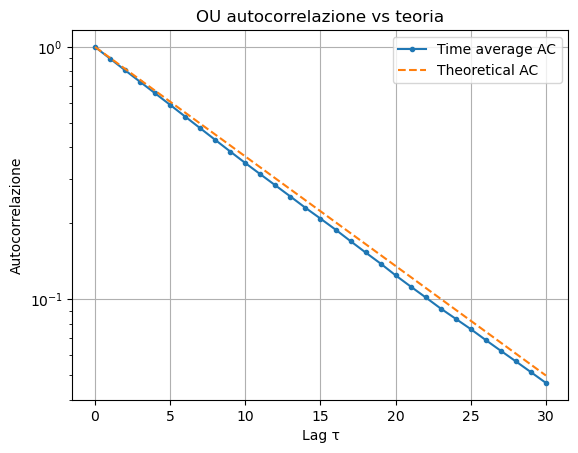

In [5]:
ac_theoretical = np.exp(-gamma * taus * dt)

plt.semilogy()
plt.plot(taus, ac_time, label="Time average AC", marker='o', markersize=3)
plt.plot(taus, ac_theoretical, label="Theoretical AC", linestyle="--")
plt.xlabel("Lag τ")
plt.ylabel("Autocorrelazione")
plt.title("OU autocorrelazione vs teoria")
plt.legend()
plt.grid(True)
plt.show()

### Ensemble Average
Insieme di N traiettorie, si valuta l'autocorrelazione tra t e t+tau di tutte le traiettorie contemporaneamente e poi si fa la media. A differenza del mixed si centrano tutte le traiettorie . E' un metodo meno dinamico ma più statistico

In [ ]:
# def ensemble_autocorr(m, nn):
#     ac = np.zeros(nn)
#     for _ in range(m):
#         x = OU(nn)
#         ac += x[0] * x
#     return ac / m
#     # Calcolo autocorrelazione per questa traiettoria
#     # Calcolo autocorrelazione media sull'ensemble

def ac_ensemble_average(X, max_tau):
    N, T = X.shape
    ac = np.zeros(max_tau+1)
    d_ac = np.zeros(max_tau+1)

    means = np.mean(X, axis=1, keepdims=True) # Media lungo ogni riga i (traiettoria)
    varsx = np.var(X, axis=1, keepdims=True) # Varianza lungo ogni riga i
    Xc = X-means # Centra ogni riga i una volta per tutti

    for tau in range(max_tau+1):
        numeratori = np.sum(Xc[:, :T-tau]*Xc[:,tau:], axis=1) # Somma di tutte le correlazioni t - t+tau fissato e traiettoria i variabile
        denominatori = (T-tau)*varsx.flatten() # Quel T-tau serve per poi con il numeratore fanno la media della corr fra t - t+tau per le traiettorie
        ac_tau = numeratori/denominatori # Ha shape N, è la ac per ogni traiettoria
        d_ac[tau] = np.std(ac_tau)
        ac[tau] = np.mean(ac_tau) # Media sulle ac di ogni traiettoria

    return ac, d_ac

### vedere se funziona
# def ensemble_avg(x,tmax): # x è array (M,T) di traiettorie per righe
#     data -= data.mean(axis=0)
#     col1 = x[:,0] # : -> prendi ogni riga, 0 -> col 1 ==> vettore lungo m delle serie al tempo 0
#     var1 = np.var(col1)
#     ac, ac_std = np.empty(tmax)
#     for t in range(tmax+1):
#         p = (col1*x[:,t])/var1 # corrisponde a fare for i in range(M):somma += X[i][0] * X[i][tau] return somma / M
#         ac.append(p.mean())
#         ac_std.append(p.std())
#     return ac, ac_std

In [7]:
T = 10**5
dt = 1.0
max_tau = 30
taus = np.arange(0, max_tau+1)
N = 100

X = np.zeros((N,T))
X[:,0] = 0.1

In [8]:
mu = 0.0
sigma = 1.0

gamma = 0.1

for i in range(N):
    for t in range(1, T):
        noise = np.random.normal(0, np.sqrt(dt))
        X[i,t] = X[i,t-1] - gamma*(X[i,t-1]-mu)*dt + sigma*noise

ac_ens, d_ac_ens = ac_ensemble_average(X, max_tau)

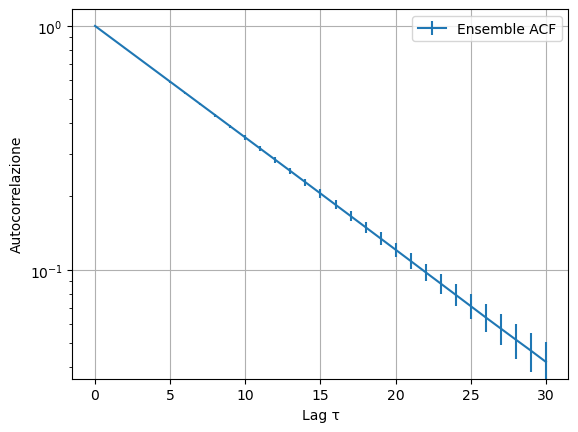

In [9]:
plt.semilogy()
plt.errorbar(taus, ac_ens, d_ac_ens, label="Ensemble ACF")
plt.xlabel("Lag τ")
plt.ylabel("Autocorrelazione")
plt.grid()
plt.legend()
plt.show()

### Mixed Average
Insieme di N traiettorie, si fa la media delle autocorrelazioni time-average per ogni singola traiettoria

In [ ]:
def ac_mixed_average(X, max_tau):
    N,T = X.shape
    ac = np.zeros((N,max_tau+1)) # Matrice ac

    # Calcolo ac time-average per ogni traiettoria
    for i in range(N):
        mean = np.mean(X[i,:])
        var = np.var(X[i,:])
        
        for tau in taus: # o for tau in range(max_tau+1):
            prod = (X[i,:T-tau]-mean)*(X[i,tau:]-mean)
            ac[i,tau] = np.mean(prod)/var

    ac_mix = np.mean(ac, axis=0)
    d_ac_mix = np.std(ac, axis=0)

    return ac_mix, d_ac_mix

In [11]:
T = 10**5
dt = 1.0
max_tau = 30
taus = np.arange(0, max_tau+1)
N = 100

X = np.zeros((N,T))
X[:,0] = 0.1

In [12]:
mu = 0.0
sigma = 1.0

gamma = 0.1

for i in range(N):
    for t in range(1,T):
        noise = np.random.normal(0, np.sqrt(dt))
        X[i,t] = X[i,t-1] - gamma*(X[i,t-1]-mu)*dt + sigma*noise

ac_mix, d_ac_mix = ac_mixed_average(X, max_tau)

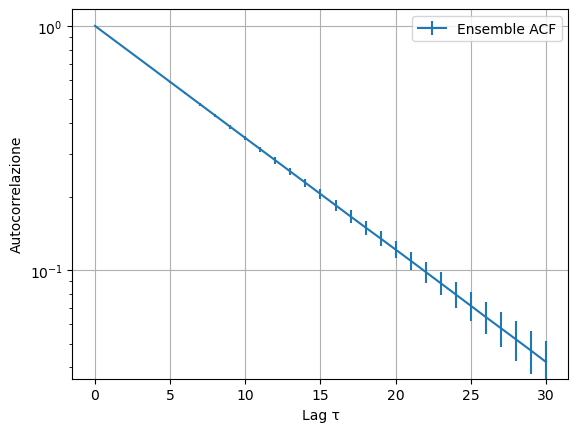

In [13]:
plt.semilogy()
plt.errorbar(taus, ac_mix, d_ac_mix, label="Ensemble ACF")
plt.xlabel("Lag τ")
plt.ylabel("Autocorrelazione")
plt.grid()
plt.legend()
plt.show()